# DQL on Chrome's Dino Run game


In [10]:
import os
import pandas as pd
import numpy as np
import random
import time
from tqdm import tqdm
from collections import deque

# image processing
import cv2
import base64
from io import BytesIO
from PIL import Image
from matplotlib import pyplot as plt

# selenium and drivers
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager

# ML (keras + tensorflow)
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam

import tensorflow as tf
from helpers import load_pkl, save_pkl

# For more repetitive results
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

### Setting notebook variables

In [2]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 32  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = '2x256'

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.999
MIN_EPSILON = 1e-3

# Model settings
LEARNING_RATE = 1e-2

#  Stats settings
AGGREGATE_STATS_EVERY = 20  # episodes


### Implementation

Our model is written in python and the game is built in JavaScript, so we need some interfacing tools for them to communicate with each other. Using the `selenium`-library, a popular browser automation tool, we can execute actions in the browser (like pressing a key), and extract information from the browser. The `Game` class is a selenium interface between this script and the browser running the Dino game.

In [3]:
class Game: 
    def __init__(self):
        options = webdriver.chrome.options.Options()
        options.add_argument("disable-infobars")
        options.add_argument("--mute-audio")
        self.driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
        self.driver.get("chrome://dino")
        self.driver.execute_script("Runner.config.ACCELERATION=0")
        self.driver.execute_script("document.getElementsByClassName('runner-canvas')[0].id = 'runner-canvas'")
    
    def __exec(self, command):
        self.driver.execute_script("Runner.instance_.{}".format(command))
        
    def __get_val(self, value): 
        return self.driver.execute_script("return Runner.instance_.{}".format(value))
    
    def press_key(self, key):
        self.driver.find_element_by_tag_name("body").send_keys(key)
        
    def pause(self):
        self.__exec("stop()")
        
    def resume(self):
        self.__exec("play()")
        
    def restart(self):
        self.__exec("restart()")
    
    def get_crashed(self):
        return self.__get_val("crashed")
    
    def get_playing(self):
        return self.__get_val("playing")
    
    def get_score(self):
        return int(''.join(self.__get_val("distanceMeter.digits")))
    
    def get_driver(self):
        return self.driver
    
    def end_game(self):
        self.driver.close()
        
    def take_screen(self):
        image_b64 = self.driver.execute_script("canvasRunner = document.getElementById('runner-canvas');\
            return canvasRunner.toDataURL().substring(22)")
        return np.array(Image.open(BytesIO(base64.b64decode(image_b64))))
    

The `take_screen` function will take a screenshot of the game. It looks something like this: 

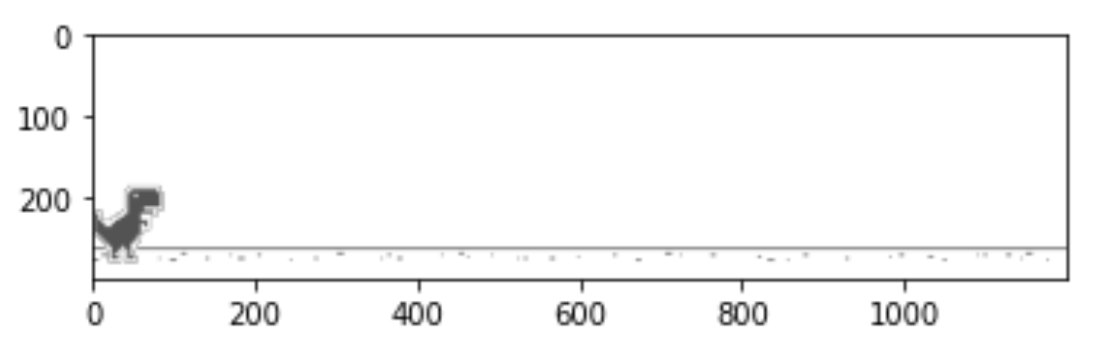

`Player` is a convenience class that can be seen as the dinosaur itself. It is simply a proxy to the `Game` class, so all actions performed by the dinosaur will go through this class.!

In [4]:
class Player: 
    def __init__(self, game): 
        self._game = game
            
    def do_action(self, choice):
        if choice == 0:  # walk
            pass
        
        if choice == 1:  # jump
            self._game.press_key(Keys.ARROW_UP)
            
        if choice == 2:  # duck
            self._game.press_key(Keys.ARROW_DOWN)
            
    def is_running(self):
        return self._game.get_playing()
    
    def is_crashed(self):
        return self._game.get_crashed()


The `GameEnv` class defines the environment and handles state progression (through the `step`-function). This class is also responsible for preprocessing screenshots, as well as putting sequences of these screenshots together which are used as inputs to our models. We use the the OpenCV library to capture screenshots, as this is what was found as the most efficient library for this task. The raw image captured has a resolution of around 1200x600 x 3 channels (RGB). We intend to use four consecutive images as inputs to our model, which gives a total dimension of 1200x300x3x4 per input. To reduce computational demand, we crop (600x300), recolor(grayscale) and resize(84x84) the image. A processed screenshot looks something like this: 

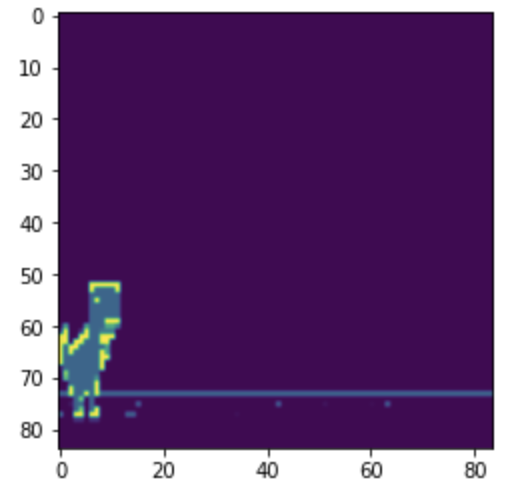

In [5]:
class GameEnv:
    MOVE_REWARD = 1
    CRASH_PENALTY = -10
    IMAGE_SIZE = (84, 84)
    OBSERVATION_SPACE_SIZE = (*IMAGE_SIZE, 4)
    ACTION_SPACE_SIZE = 2
    
    def __init__(self, game, player):
        self._game = game
        self._player = player
        
        self.current_state = self.get_initial_state()
            
    def get_preprocessed_screenshot(self):
        screen = self._game.take_screen()
        image = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
        image = image[:300, :600]
        image = cv2.resize(image, self.IMAGE_SIZE)
        return image
    
    def get_initial_state(self):
        observation = self.get_preprocessed_screenshot()
        return np.stack((observation, observation, observation, observation), axis=2)

    def step(self, action):
        self._player.do_action(action)
        
        reward = self.MOVE_REWARD
        done = False
        
        new_observation = self.get_preprocessed_screenshot()  # (80, 80)
        new_state = np.append(new_observation.reshape(*new_observation.shape, 1), self.current_state[:,:,:-1], axis=2)
        self.current_state = new_state

        if self._player.is_crashed():
            reward = self.CRASH_PENALTY
            done = True

        return new_state, reward, done
    

The `DQNAgent` class handles the network and training of the network. Some things to notice about this class: 
- We define _two_ models: `model` and `target_model`. Every step we make in an episode, we want to update the Q-values (fit), but we are also trying to predict with our model. This causes _a lot_ of fit-operations and predicts, which intuitively can be quite confusing. To ensure some consistency, we therefore define two models - one that is fit every step, and one that predicts every step. `target_model` is updated with `model`'s weights every nth step. _I do not know if this is helpful or not._

- Model inputs are 4 consecutive screenshots in time (processed, as described above). Size = (84, 84, 4).
- Model outputs are 2 neurons, representing the maximum predicted reward for each action.
- The network is trained weith a variant of the Q-learning algorithm, with stochastic gradient descent to update the weights.

- We use `replay_memory` to store transitions of form (current_state, action, reward, new_current_state, done). 
> To alleviate the problems of correlated data and non-stationary distributions, we use an experience replay mechanism which randomly samples previous transitions, and thereby smooths the training distribution over many past behaviors ([source](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf))

- We only train in batches. So for every step, we sample a `MINIBATCH_SIZE` of observations from `replay_memory`, and fit our model on this batch.

- The pseudocode for what's happening is seen here ([source](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)):
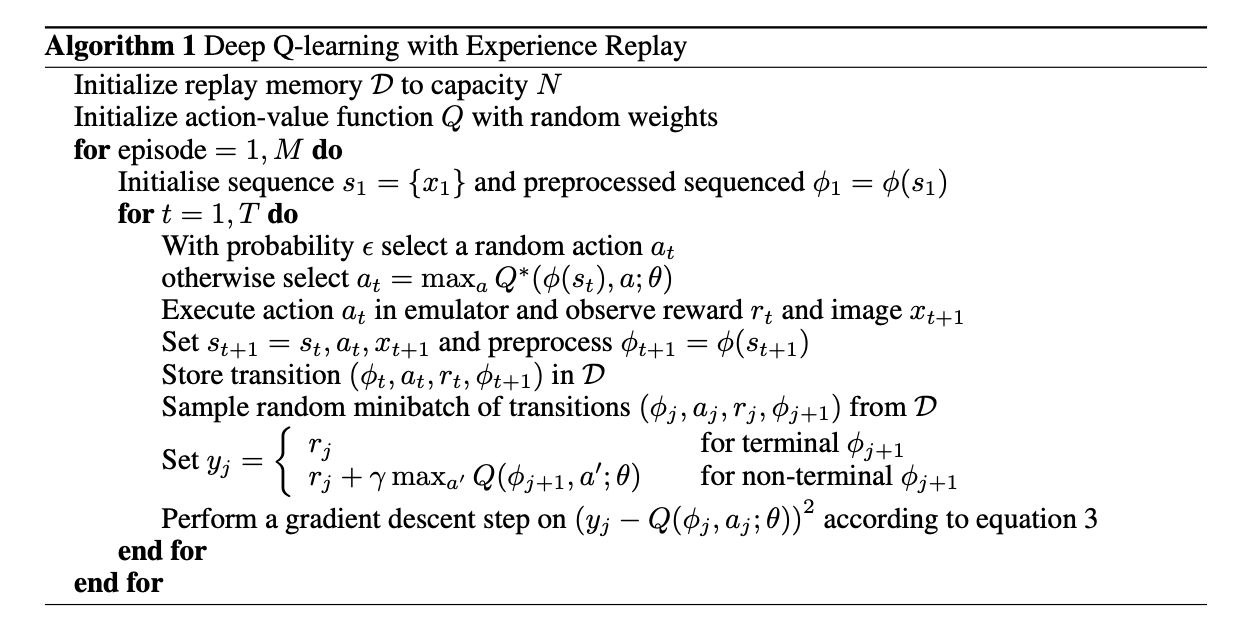

In [6]:
class DQNAgent:
    def __init__(self, env):

        # Main model
        self.model = self.create_model()

        # Target network (updated every nth step)
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0
        
        self.env = env
    
    def create_model(self):
        model = Sequential()
        
        model.add(Conv2D(32, (8, 8), padding='same',strides=(4, 4),input_shape=env.OBSERVATION_SPACE_SIZE))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Activation('relu'))
        
        model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Activation('relu'))
        
        model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Activation('relu'))
        
        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation('relu'))
        
        model.add(Dense(env.ACTION_SPACE_SIZE))
        model.compile(loss='mse', optimizer=Adam(lr=LEARNING_RATE))
        
        return model
    
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)
    
    # Trains main network every step during episode
    def train(self, terminal_state):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states/255)

        # Get future states from minibatch, then query NN model for Q values
        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states/255)

        X, y = [], []
        
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)
            
        # Fit on all samples as one batch
        self.model.fit(np.array(X)/255, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False, callbacks=None)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter >= UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0
                
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]


### Main run function

In [7]:
game = Game()
player = Player(game)
env = GameEnv(game, player)
agent = DQNAgent(env) 

def initialize_file_structure():
    if not os.path.isdir('./models'): 
        os.makedirs('./models')
    if not os.path.isdir('./stats'): 
        os.makedirs('./stats')
    if not os.path.isdir('./store'): 
        os.makedirs('./store')     

initialize_file_structure()

# CONTINUE_FROM_CHECKOUT decides whether you want to "start over" or continue from latest checkpoint.
# NB: This is not "fail safe", meaning that it does not check if the files exist. 
# You must therefore run once with this variable set to False to initialize files.
CONTINUE_FROM_CHECKPOINT = False 

if (CONTINUE_FROM_CHECKPOINT):
    # load stats
    ep_stats = pd.read_csv(f'./stats/{MODEL_NAME}-ep_stats.csv')
    ep_rewards = np.load(f'./stats/{MODEL_NAME}-ep_rewards.npy')
    ep_scores = np.load(f'./stats/{MODEL_NAME}-ep_scores.npy')
    highscore = max(ep_scores)
    
    # load parameters
    notebook_checkpoint = load_pkl(f'./store/{MODEL_NAME}-notebook_checkpoint.pkl')
    epsilon = notebook_checkpoint['epsilon']
    episode = notebook_checkpoint['episode']
    
    # load the last saved model
    agent.model.load_weights(f'./store/{MODEL_NAME}-latest_weights.h5')
    agent.target_model.load_weights(f'./store/{MODEL_NAME}-latest_weights.h5')
    
    # load replay memory
    agent.replay_memory = load_pkl(f'./store/{MODEL_NAME}-replay_memory.pkl')
    
else: 
    ep_stats = pd.DataFrame([], columns=["episode", "min_reward", "max_reward", "avg_reward", "min_score", "max_score", "avg_score", "epsilon"])
    ep_rewards, ep_scores = np.array([]), np.array([])
    highscore = -200
    episode = 0


Looking for [chromedriver 81.0.4044.69 mac64] driver in cache 
File found in cache by path [/Users/halvorreiten/.wdm/drivers/chromedriver/81.0.4044.69/mac64/chromedriver]


In [ ]:
EPISODES = 30

# Iterate over episodes
for ep in tqdm(range(episode+1, EPISODES+1), ascii=True, unit='episodes'):

    # Restarting episode - reset episode reward
    episode_reward = 0

    # Reset environment and get initial state
    current_state = env.get_initial_state()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get a random action
            action = np.random.randint(0, env.ACTION_SPACE_SIZE)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done)

        current_state = new_state

    episode_score = game.get_score()
    
    # Save model if it is a new highscore
    if (episode_score > highscore):
        print(f'New highscore: {episode_score}. Saving model...')
        agent.model.save(f'./models/{MODEL_NAME}-highscore-{episode_score}.model')
        highscore = episode_score
    
    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards = np.append(ep_rewards, episode_reward)
    ep_scores = np.append(ep_scores, episode_score)
    
    if not ep % AGGREGATE_STATS_EVERY or ep == 1:
        average_reward = ep_rewards[-AGGREGATE_STATS_EVERY:].mean()
        min_reward = ep_rewards[-AGGREGATE_STATS_EVERY:].min()
        max_reward = ep_rewards[-AGGREGATE_STATS_EVERY:].max()
        
        avg_score = ep_scores[-AGGREGATE_STATS_EVERY:].mean()
        min_score = ep_scores[-AGGREGATE_STATS_EVERY:].min()
        max_score = ep_scores[-AGGREGATE_STATS_EVERY:].max()
        
        ep_stats.loc[len(ep_stats)] = [ep, min_reward, max_reward, average_reward,min_score,max_score,avg_score,epsilon]
                
        # Save stats
        ep_stats.to_csv(f'./stats/{MODEL_NAME}-ep_stats.csv', index=False)
        np.save(f'./stats/{MODEL_NAME}-ep_rewards.npy', ep_rewards)
        np.save(f'./stats/{MODEL_NAME}-ep_scores.npy', ep_scores)
        
        # Save notebook checkpoint
        notebook_params = {'episode': ep, 'epsilon': epsilon}
        save_pkl(f'./store/{MODEL_NAME}-notebook_checkpoint.pkl', notebook_params)
        
        # Save replay memory
        save_pkl(f'./store/{MODEL_NAME}-replay_memory.pkl', agent.replay_memory)
        
        # Save model weights
        agent.model.save_weights(f'./store/{MODEL_NAME}-latest_weights.h5')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
    
    game.restart()